In [1]:
from qiskit import Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import HGate, SGate, TGate, XGate, YGate, ZGate, CCXGate
from qiskit.circuit import QuantumCircuit, Measure
import numpy as np

In [2]:
import copy

In [3]:
def inject_error(G, error_type, num_errors=1):
    """Injects errors into the given quantum circuit.

    Args:
        circuit (QuantumCircuit): The quantum circuit to inject errors into.
        error_type (str): The type of error to inject. Options are 'remove', 'insert', 'toffoli_beginning', 'toffoli_end'.
        num_errors (int): The number of errors to inject.

    Returns:
        QuantumCircuit: The quantum circuit with injected errors.
    """
    circuit = copy.deepcopy(G)
    gate_dict = {'X': XGate(), 'Y': YGate(), 'Z': ZGate(), 'H': HGate(), 'S': SGate(), 'T': TGate()}
    
    if error_type == 'toffoli_beginning' or error_type == 'toffoli_end':
        num_errors = 10

    for _ in range(num_errors):
        if error_type == 'remove':
            if len(circuit.data) > 0:  # Check if there are gates to remove
                n = range(len(circuit.data))
                remove_idx = [idx for idx in n if not isinstance(circuit.data[idx].operation, Measure)]
                idx = np.random.choice(remove_idx)
                circuit.data.pop(idx)

        elif error_type == 'insert':
            gate = np.random.choice(list(gate_dict.keys()))
            idx = np.random.randint(len(circuit.data) + 1)
            qubit = np.random.choice(circuit.qubits)
            circuit.data.insert(idx, (gate_dict[gate], [qubit], []))

        elif error_type == 'toffoli_beginning':
            qubits = np.random.choice(range(circuit.num_qubits), size=3, replace=False)
            circuit.data.insert(0, (CCXGate(), [circuit.qubits[i] for i in qubits], []))

        elif error_type == 'toffoli_end':
            qubits = np.random.choice(range(circuit.num_qubits), size=3, replace=False)
            circuit.data.append((CCXGate(), [circuit.qubits[i] for i in qubits], []))

    return circuit


In [4]:
from qiskit import QuantumCircuit
# Example usage:
circuit = QuantumCircuit(5)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
print("Original circuit:")
print(circuit)
circuit_with_error = inject_error(circuit, 'toffoli_beginning', 1)
# circuit_with_error = inject_error(circuit, 'insert', 2)
print("\nCircuit with error:")
print(circuit_with_error)

Original circuit:
        ┌───┐      ░ ┌─┐            
   q_0: ┤ H ├──■───░─┤M├────────────
        └───┘┌─┴─┐ ░ └╥┘┌─┐         
   q_1: ─────┤ X ├─░──╫─┤M├─────────
             └───┘ ░  ║ └╥┘┌─┐      
   q_2: ───────────░──╫──╫─┤M├──────
                   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────░──╫──╫──╫─┤M├───
                   ░  ║  ║  ║ └╥┘┌─┐
   q_4: ───────────░──╫──╫──╫──╫─┤M├
                   ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════╩══╩══╩══╩══╩═
                      0  1  2  3  4 

Circuit with error:
                                                          ┌───┐      ░ ┌─┐   »
   q_0: ──■─────────■────■────■─────────■─────────■────■──┤ H ├──■───░─┤M├───»
          │         │    │  ┌─┴─┐       │         │    │  └───┘┌─┴─┐ ░ └╥┘┌─┐»
   q_1: ──┼─────────┼────┼──┤ X ├───────┼─────────┼────┼───────┤ X ├─░──╫─┤M├»
          │  ┌───┐┌─┴─┐  │  └─┬─┘┌───┐┌─┴─┐┌───┐┌─┴─┐  │       └───┘ ░  ║ └╥┘»
   q_2: ──┼──┤ X ├┤ X ├──■────■──┤ X ├┤ X ├┤ X ├┤ X ├──■─────────────░──╫──╫─»
      

In [5]:
import os

original_circuit_list = []
original_circuit_names = []
original_directory = "./circuits/original/"
for filename in sorted(os.listdir(original_directory)):
    if filename.endswith(".qasm"): 
        circ = QuantumCircuit.from_qasm_file(original_directory+filename)
        original_circuit_names.append(original_directory+filename)
        original_circuit_list.append(circ)
        

transpiled_circuit_list = []
transpiled_circuit_names = []
transpiled_directory = "./circuits/transpiled/"
for filename in sorted(os.listdir(transpiled_directory)):
    if filename.endswith(".qasm"): 
        circ = QuantumCircuit.from_qasm_file(transpiled_directory+filename)
        transpiled_circuit_names.append(transpiled_directory+filename)
        transpiled_circuit_list.append(circ)

In [6]:
from mqt import qcec

# verify the equivalence of two circuits provided as qasm files
# result = qcec.verify(original_circuit_names[5], transpiled_circuit_names[5])

result = qcec.verify(original_circuit_list[5], transpiled_circuit_list[5])

# print the result
print(result.equivalence)

equivalent_up_to_global_phase


In [7]:
from qiskit import execute, Aer
from collections import Counter
from qiskit.quantum_info.analysis import hellinger_fidelity

def are_circuits_equivalent(circuit1, circuit2, shots=1000):
    """Check if two quantum circuits are equivalent by comparing their measurement probabilities.

    Args:
        circuit1 (QuantumCircuit): The first quantum circuit.
        circuit2 (QuantumCircuit): The second quantum circuit.
        shots (int): The number of shots to use for the quantum simulation.

    Returns:
        bool: True if the circuits are equivalent, False otherwise.
    """
    simulator = Aer.get_backend('qasm_simulator')

    job1 = execute(circuit1, simulator, shots=shots)
    counts1 = job1.result().get_counts()

    job2 = execute(circuit2, simulator, shots=shots)
    counts2 = job2.result().get_counts()

    # Normalize the counts to probabilities
    counts1 = {k: v / shots for k, v in counts1.items()}
    counts2 = {k: v / shots for k, v in counts2.items()}

    # Fill in missing keys with zero counts
    counts1 = Counter(counts1)
    counts2 = Counter(counts2)
    counts1 += Counter({k: 0 for k in counts2.keys() if k not in counts1})
    counts2 += Counter({k: 0 for k in counts1.keys() if k not in counts2})
    
    counts1_keys = sorted(counts1)
    counts2_keys = sorted(counts2)
    
    new_counts1 = {key:counts1[key] for key in counts1_keys}
    new_counts2 = {key:counts2[key] for key in counts2_keys}
    
    counts1_array = np.array(list(new_counts1.values()))
    counts2_array = np.array(list(new_counts2.values()))
    
    # check fidelity with Helinger_fidelity    
    fidelity = hellinger_fidelity(new_counts1, new_counts2)

    # Check if the fidelity is close to 1
    return np.abs(1 - fidelity) < 0.1 # at least 90% fidelity is acceptable


In [8]:
U = original_circuit_list[18]
G = transpiled_circuit_list[18]

are_circuits_equivalent(U, G)

True

In [9]:
result = qcec.verify(U, G)

# print the result
print(result.equivalence)

equivalent_up_to_global_phase


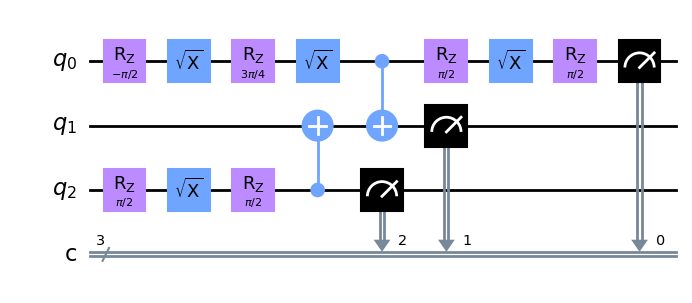

In [10]:
G.draw("mpl")

In [11]:
G_with_error = inject_error(G, 'remove', 3)

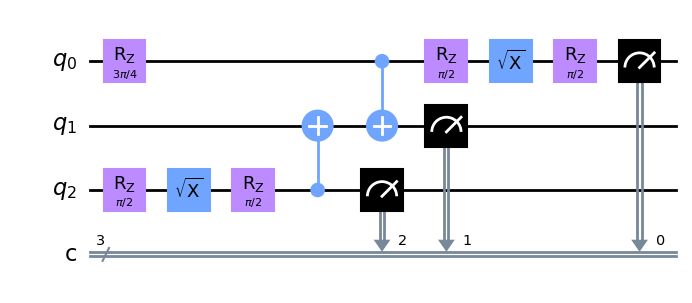

In [12]:
G_with_error.draw("mpl")

In [13]:
are_circuits_equivalent(U, G_with_error)

False

In [14]:
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import random_unitary
# import numpy as np

# def classical_stimuli(G: QuantumCircuit):
#     """Applies random Pauli gates to each qubit of the circuit."""
#     circuit = copy.deepcopy(G)
#     pauli_gates = [lambda q: circuit.i(q), lambda q: circuit.x(q), 
#                    lambda q: circuit.y(q), lambda q: circuit.z(q)]
#     for qubit in range(circuit.num_qubits):
#         np.random.choice(pauli_gates)(qubit)
#     return circuit

# def local_quantum_stimuli(G: QuantumCircuit):
#     """Applies random rotations around the Bloch sphere to each qubit of the circuit."""
#     circuit = copy.deepcopy(G)
#     for qubit in range(circuit.num_qubits):
#         circuit.u(*np.random.uniform(0, 2*np.pi, 3), qubit)  # Random single-qubit unitary
#     return circuit

# def global_quantum_stimuli(G: QuantumCircuit):
#     """Applies a random unitary operation to all qubits of the circuit."""
#     circuit = copy.deepcopy(G)
#     random_gate = random_unitary(2**circuit.num_qubits)  # Random many-qubit unitary
#     circuit.unitary(random_gate, range(circuit.num_qubits))
#     return circuit


In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import XGate, HGate, SGate, IGate
import numpy as np

def classical_stimuli(G: QuantumCircuit):
    """Prepares the circuit in a random computational basis state."""
    circuit = copy.deepcopy(G)
    bitstring = np.random.choice([0, 1], circuit.num_qubits)  # Random bitstring
    stimuli = QuantumCircuit(circuit.num_qubits)
    for qubit, bit in enumerate(bitstring):
        if bit:
            stimuli.x(qubit)  # Apply an X gate if the bit in the bitstring is 1
    
    stimuli.barrier()
    return stimuli.compose(circuit)

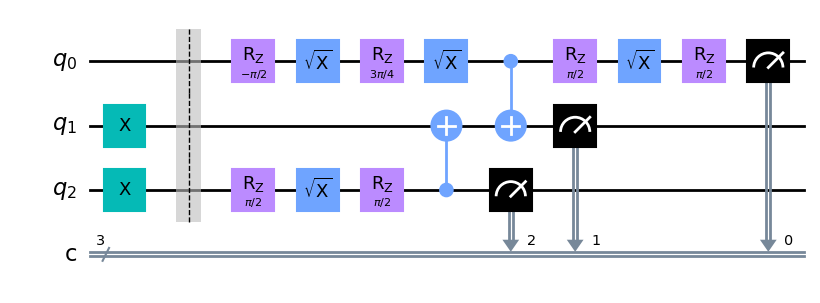

In [16]:
classical_stimuli(G).draw("mpl")

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, HGate, SGate, IGate

def local_stimuli(G: QuantumCircuit):
    """Applies a random gate from the set {I, X, H, XH, HS, XHS} to each qubit."""
    circuit = copy.deepcopy(G)
    stimuli = QuantumCircuit(circuit.num_qubits)
    
    def I_gates(q):
        stimuli.i(q)
        
    def X_gates(q):
        stimuli.x(q)
        
    def H_gates(q):
        stimuli.h(q)
        
    def XH_gates(q):
        stimuli.x(q)
        stimuli.h(q)
        
    def HS_gates(q):
        stimuli.h(q)
        stimuli.s(q)
        
    def XHS_gates(q):
        stimuli.x(q)
        stimuli.h(q)
        stimuli.s(q)
    
    gates_list = [lambda q: I_gates(q), lambda q: X_gates(q),lambda q: H_gates(q), 
                  lambda q: XH_gates(q), lambda q: HS_gates(q),lambda q: XHS_gates(q)]

    for qubit in range(stimuli.num_qubits):
        np.random.choice(gates_list)(qubit)
        
    stimuli.barrier()

    return stimuli.compose(circuit)


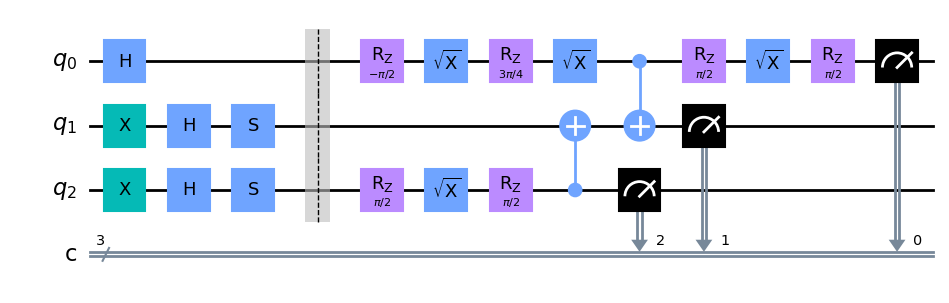

In [18]:
local_stimuli(G).draw("mpl")

In [19]:
# from qiskit import QuantumCircuit
# from qiskit.circuit.library import CXGate, HGate, SGate
# import random

# def global_stimuli(G: QuantumCircuit, num_layers: int = 2):
#     """Generates global stimuli for a given quantum circuit.

#     Args:
#         G (QuantumCircuit): The quantum circuit for which to generate stimuli.
#         num_layers (int): The number of gate layers in the stimuli.

#     Returns:
#         QuantumCircuit: The resulting quantum circuit after applying the stimuli.
#     """
#     # Copy the circuit
#     circuit = copy.deepcopy(G)

#     # Create a new circuit for the stimuli
#     stimuli = QuantumCircuit(circuit.num_qubits)

#     # Define the gates
#     gates = [HGate(), SGate(), CXGate()]
    
#     # randomly select the number of layers (l>1) based on the number of qubits in the circuit
#     n = circuit.num_qubits
#     if n > 2:
#         num_layers = random.choice(range(2, n+1))

#     for _ in range(num_layers):
#         # Choose a random gate for each qubit
#         for qubit in range(circuit.num_qubits):
#             # gate = np.random.choice(gates)
#             gate = random.choice(gates)

#             # For single-qubit gates
#             if not isinstance(gate, CXGate):
#                 stimuli.append(gate, [qubit])
            
#             # For two-qubit gates (CNOT)
#             else:
#                 control_qubit = qubit
#                 qubits_list = list(range(circuit.num_qubits))
#                 qubits_list.remove(control_qubit)
#                 target_qubit = np.random.choice(qubits_list)
#                 stimuli.append(gate, [control_qubit, target_qubit])
                
#         stimuli.barrier()

#     # Compose the stimuli with the original circuit
#     combined_circuit = stimuli.compose(circuit)

#     return combined_circuit


In [20]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import CXGate, HGate, SGate
import random

def global_stimuli(G: QuantumCircuit, num_layers: int = 2):
    """Generates global stimuli for a given quantum circuit.

    Args:
        G (QuantumCircuit): The quantum circuit for which to generate stimuli.
        num_layers (int): The number of gate layers in the stimuli.

    Returns:
        QuantumCircuit: The resulting quantum circuit after applying the stimuli.
    """
    # Copy the circuit
    circuit = copy.deepcopy(G)

    # Create a new circuit for the stimuli
    stimuli = QuantumCircuit(circuit.num_qubits)
    
    def I_gates(q):
        stimuli.i(q)
        
    def X_gates(q):
        stimuli.x(q)
        
    def H_gates(q):
        stimuli.h(q)
        
    def S_gates(q):
        stimuli.s(q)
        
    def XH_gates(q):
        stimuli.x(q)
        stimuli.h(q)
        
    def HS_gates(q):
        stimuli.h(q)
        stimuli.s(q)
        
    def XHS_gates(q):
        stimuli.x(q)
        stimuli.h(q)
        stimuli.s(q)
    
    gates = [lambda q: I_gates(q), lambda q: X_gates(q),lambda q: H_gates(q), lambda q: S_gates(q),
                  lambda q: XH_gates(q), lambda q: HS_gates(q),lambda q: XHS_gates(q), CXGate()]

    # for qubit in range(stimuli.num_qubits):
    #     np.random.choice(gates_list)(qubit)

    # Define the gates
    # gates = [HGate(), SGate(), CXGate()]
    
    # randomly select the number of layers (l>1) based on the number of qubits in the circuit
    n = circuit.num_qubits
    if n > 2:
        num_layers = random.choice(range(2, n+1))

    for _ in range(num_layers):
        # Choose a random gate for each qubit
        for qubit in range(circuit.num_qubits):
            # gate = np.random.choice(gates)
            gate = random.choice(gates)

            # For single-qubit gates
            if not isinstance(gate, CXGate):
                # stimuli.append(gate, [qubit])
                gate(qubit)
            
            # For two-qubit gates (CNOT)
            else:
                control_qubit = qubit
                qubits_list = list(range(circuit.num_qubits))
                qubits_list.remove(control_qubit)
                target_qubit = np.random.choice(qubits_list)
                stimuli.append(gate, [control_qubit, target_qubit])
                
        stimuli.barrier()

    # Compose the stimuli with the original circuit
    combined_circuit = stimuli.compose(circuit)

    return combined_circuit


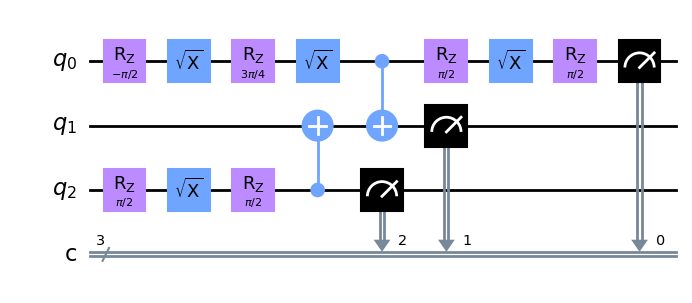

In [21]:
G.draw("mpl")

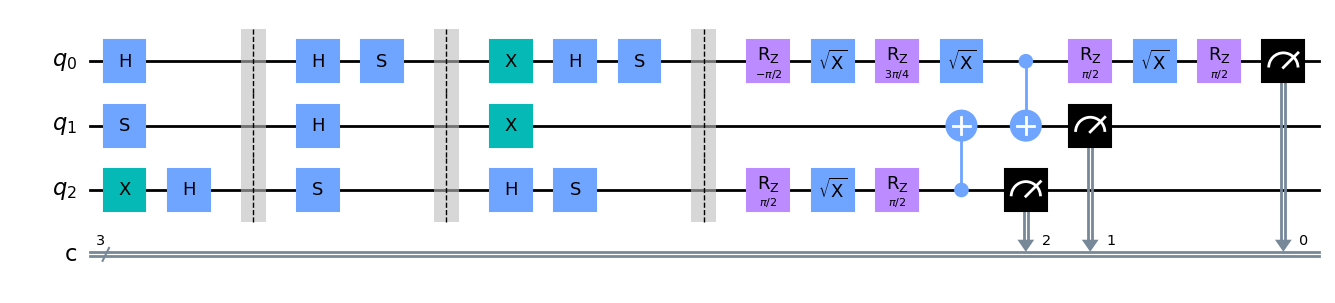

In [22]:
global_stimuli(G).draw("mpl")

In [23]:
import time

error_type = 'remove'
num_errors = 1



stimuli_names_methods = {"classical": classical_stimuli, "local": local_stimuli, "global": global_stimuli}
stimuli_results = {"classical": [], "local": [], "global": []}
error_detection_rate = {"classical": [], "local": [], "global": []} # the probability that the error is detected 
                                                                    # by the generated set of stimuli
runtime = {"classical": [], "local": [], "global": []}   # the runtime ∅t of the respective scheme in seconds
# num_stimuli = [] # the number of stimuli ∅s needed to detect the error

for U, G in zip(original_circuit_list, transpiled_circuit_list):
    
    # For each error-injection option, 50 random seeds have been considered.
    for _ in range(50):
        # Step 4: Inject errors into the circuit
        G_with_error = inject_error(G, error_type, num_errors)

        # Step 5: Generate random stimuli
        for name, method in stimuli_names_methods.items():
            is_equivalent = True

            stimuli_detection = [] # add 1 to list if stimuli detects error and 0 otherwise
            start_time = time.time()
            # For each resulting instance, 5 random seeds have been used for 
            # randomly picking stimuli according to the respective scheme.
            for _ in range(5):
                G_with_stimuli = method(G_with_error)

                # Step 6: Perform simulations
                # Step 7: Detect the injected error
                is_equivalent = are_circuits_equivalent(U, G_with_stimuli)

                value = int(not is_equivalent) # if is_equivalent is False, error is detected and value=1, otherwise, value=0
                stimuli_detection.append(value)

            num_stimuli_to_detect_error = sum(stimuli_detection)  # Total number of stimuli that detected error
            
            # The number of stimuli ∅s needed to detect the error.
            # The index of the first 1 (first time it was correctly detected)
            # plus 1 to account for zero indexing
            if 1 in stimuli_detection:
                first_stimuli_to_detect_error = stimuli_detection.index(1) + 1
            else:
                first_stimuli_to_detect_error = 5+1 # more than 5 stimuli are needed

            stop_time = time.time()
            # Step 8: Collect the results
            stimuli_results[name].append(first_stimuli_to_detect_error)
            error_detection_rate[name].append((100*num_stimuli_to_detect_error/5))
            runtime[name].append((stop_time - start_time))

In [24]:
average_num_stimuli = {}
for name, results in stimuli_results.items():
    std = np.std(results)
    mean = sum(results)/len(results)
    average_num_stimuli[name] = f"{mean:.1f} " + u"\u00B1" f" {std:.1f}"
    
average_error_detection_rate = {}
for name, results in error_detection_rate.items():
    std = np.std(results)
    mean = sum(results)/len(results)
    average_error_detection_rate[name] = f"{mean:.1f} " + u"\u00B1" f" {std:.1f}"
    
average_runtime = {}
for name, results in runtime.items():
    std = np.std(results)
    mean = sum(results)/len(results)
    average_runtime[name] = f"{mean:.1f} " + u"\u00B1" f" {std:.1f}"

In [25]:
average_num_stimuli

{'classical': '1.3 ± 1.1', 'local': '1.0 ± 0.2', 'global': '1.0 ± 0.2'}

In [26]:
average_error_detection_rate

{'classical': '87.6 ± 26.0', 'local': '97.8 ± 7.7', 'global': '97.7 ± 7.6'}

In [27]:
average_runtime

{'classical': '0.3 ± 0.2', 'local': '0.3 ± 0.3', 'global': '0.4 ± 0.3'}

In [29]:
# stimuli_results

In [30]:
experiments = {"Remove 1 random gate": ("remove", 1), "Remove 2 random gates": ("remove", 2), 
 "Remove 3 random gates": ("remove", 3), "Add 1 random gate": ("insert", 1), 
 "Add 2 random gate": ("insert", 2), "Add 3 random gate": ("insert", 3),
 "Add 10 random Toffolis at beginning": ("toffoli_beginning", 10), 
 "Add 10 random Toffolis at end": ("toffoli_end", 10)}

In [34]:
for exprt, (error_type, num_errors) in experiments.items():
    print(error_type, num_errors)

remove 1
remove 2
remove 3
insert 1
insert 2
insert 3
toffoli_beginning 10
toffoli_end 10
